# Adaptive Edge Detection in Smoke-Augmented BSDS500 Images

This notebook implements a hybrid edge detection pipeline using the BSDS500 dataset. The pipeline consists of:
1. **Smoke Augmentation:** Adding natural smoke overlays (using synthetic simulation) at varying densities.
2. **Edge Detection Algorithms:** Experimenting with several edge detectors (Canny, Sobel, Laplacian, and a simulated deep method).
3. **Smoke Level Estimation:** A simple CNN to predict smoke intensity (Low, Medium, High).
4. **Adaptive Edge Detection:** Dynamically choosing the best edge detector based on the predicted smoke level.
5. **Evaluation:** Comparing detected edges against ground truth (loaded from BSDS500 .mat files) using metrics such as F1-score, IoU, and SSIM.

**Dataset Integration:**  
The BSDS500 dataset is assumed to have the following folder structure (adjust paths if needed):
- `BSDS500/images/test/` — contains test images (JPEG or PNG)
- `BSDS500/ground_truth/test/` — contains corresponding ground truth .mat files  
Make sure you have downloaded and unzipped the dataset from Kaggle into the appropriate folders.

In [71]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import f1_score, jaccard_score
import tensorflow as tf
import pandas as pd

from keras import Sequential
from keras.api.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.api.utils import to_categorical

import scipy.io as sio

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

## 1. Dataset Loading (BSDS500)

Update the paths below to point to the BSDS500 dataset downloaded from Kaggle.
We assume that the test images are stored under `BSDS500/images/test/` and their corresponding ground truth in `BSDS500/ground_truth/test/`.

In [72]:
# Set dataset directories (update these paths as needed)
dataset_dir = 'BSDS500'  # Folder where BSDS500 is unzipped
images_dir = os.path.join(dataset_dir, 'images', 'test')
gt_dir = os.path.join(dataset_dir, 'ground_truth', 'test')

# List image files (supports jpg and png)
image_files = glob.glob(os.path.join(images_dir, '*.jpg')) + glob.glob(os.path.join(images_dir, '*.png'))
if len(image_files) == 0:
    raise Exception("No images found in the dataset directory. Please check your dataset path.")

# Load a random sample image from the dataset
sample_image_path = random.choice(image_files)
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
print("Loaded sample image:", sample_image_path)

Loaded sample image: BSDS500/images/test/223060.jpg


## 2. Ground Truth Loader for BSDS500

BSDS500 ground truth files are stored in .mat format. The following function loads the ground truth edges for a given image.
It assumes that the ground truth file shares the same base name as the image file.

In [73]:
def load_ground_truth_edges(image_path, gt_dir):
    """
    Load ground truth edges from a BSDS500 .mat file corresponding to image_path.

    Returns:
        combined (numpy array): Binary edge map (0 or 255).
    """
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    gt_path = os.path.join(gt_dir, base_name + '.mat')
    if not os.path.exists(gt_path):
        print(f"Ground truth file not found for {image_path}. Using Canny on original image as simulated GT.")
        return detect_edges_canny(sample_image)
    gt_data = sio.loadmat(gt_path)
    # The ground truth is stored in a cell array called 'groundTruth'
    gt_cell = gt_data['groundTruth'][0]
    # Initialize combined edge map with zeros (same size as the first annotation)
    combined = np.zeros(gt_cell[0]['Boundaries'][0, 0].shape, dtype=np.bool_)
    # Combine each annotation's boundaries using logical OR
    for gt in gt_cell:
        edge_map = gt['Boundaries'][0, 0]
        combined = np.logical_or(combined, edge_map)
    combined = (combined.astype(np.uint8)) * 255
    return combined

## 3. Smoke Augmentation

We simulate smoke by generating a noise image, blurring it, and then alpha blending it with the original image.

In [74]:
def add_smoke_overlay(image, opacity=0.5):
    """
    Adds a smoke-like overlay to an image using random noise and Gaussian blur.

    Parameters:
        image (numpy array): Original image.
        opacity (float): Opacity level of the smoke overlay (0 to 1).

    Returns:
        Augmented image with smoke overlay.
    """
    noise = np.random.rand(*image.shape[:2]).astype(np.float32)
    noise = (noise * 255).astype(np.uint8)
    smoke = cv2.GaussianBlur(noise, (21, 21), 0)
    if len(image.shape) == 3 and image.shape[2] == 3:
        smoke = cv2.cvtColor(smoke, cv2.COLOR_GRAY2BGR)
    image_float = image.astype(np.float32) / 255.0
    smoke_float = smoke.astype(np.float32) / 255.0
    augmented = cv2.addWeighted(image_float, 1.0, smoke_float, opacity, 0)
    augmented = np.clip(augmented * 255, 0, 255).astype(np.uint8)
    return augmented

### Visualize Smoke Augmentation on a BSDS500 Sample

We display the sample image augmented with various smoke opacities.

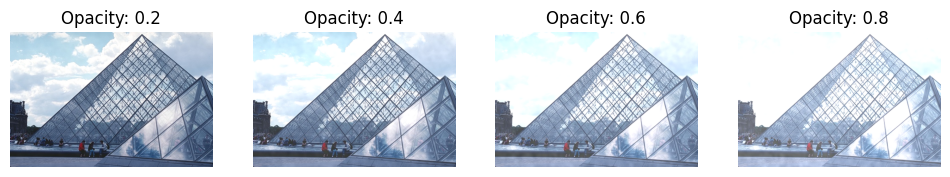

In [75]:
opacities = [0.2, 0.4, 0.6, 0.8]
plt.figure(figsize=(12, 3))
for i, opacity in enumerate(opacities):
    augmented = add_smoke_overlay(sample_image, opacity)
    plt.subplot(1, len(opacities), i + 1)
    plt.imshow(augmented)
    plt.title(f'Opacity: {opacity}')
    plt.axis('off')
plt.show()

## 4. Edge Detection Algorithms

We implement several edge detectors:
- **Canny**
- **Sobel**
- **Laplacian**
- **HED (simulated):** Here simulated via histogram equalization followed by Canny.

In [82]:
def detect_edges_canny(image, low_threshold=30, high_threshold=100):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    return edges


def detect_edges_sobel(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    edges = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    _, edges = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)
    return edges


def detect_edges_laplacian(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    edges = cv2.convertScaleAbs(lap)
    _, edges = cv2.threshold(edges, 30, 255, cv2.THRESH_BINARY)
    return edges


def detect_edges_hed_deep(image):
    # Load the pre-trained HED model (ensure the files are in your working directory)
    prototxt_path = "./model/deploy.prototxt"
    caffemodel_path = "./model/hed_pretrained_bsds.caffemodel"
    net = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(image.shape[1], image.shape[0]),
                                 mean=(104.00698793, 116.66876762, 122.67891434),
                                 swapRB=False, crop=False)
    net.setInput(blob)
    hed = net.forward()
    hed = hed[0, 0]  # Extract the edge map from the network output
    hed = cv2.resize(hed, (image.shape[1], image.shape[0]))
    hed = (255 * hed).astype(np.uint8)
    _, hed = cv2.threshold(hed, 50, 255, cv2.THRESH_BINARY)
    return hed

def weighted_fuse_edges(edges, weights=None):
    if weights is None:
        weights = [1.0 / len(edges)] * len(edges)
    fused = np.zeros_like(edges[0], dtype=np.float32)
    for edge, w in zip(edges, weights):
        fused += w * edge.astype(np.float32)
    # Normalize to 0-255 and convert to uint8
    fused = np.clip(fused, 0, 255).astype(np.uint8)
    # Apply dilation to account for slight misalignments
    kernel = np.ones((3, 3), np.uint8)
    fused = cv2.dilate(fused, kernel, iterations=1)
    # Optionally threshold the fused image
    _, fused = cv2.threshold(fused, 50, 255, cv2.THRESH_BINARY)
    # If fused has shape (2, height, width), transpose to (height, width, 2)
    if fused.ndim == 3 and fused.shape[0] == 2:
        fused = fused.transpose(1, 2, 0)
    return fused

### Visualize Edge Detection Results on a Smoke-Augmented Image
We apply all edge detectors on a smoke-augmented sample image (opacity=0.5) and display the results.


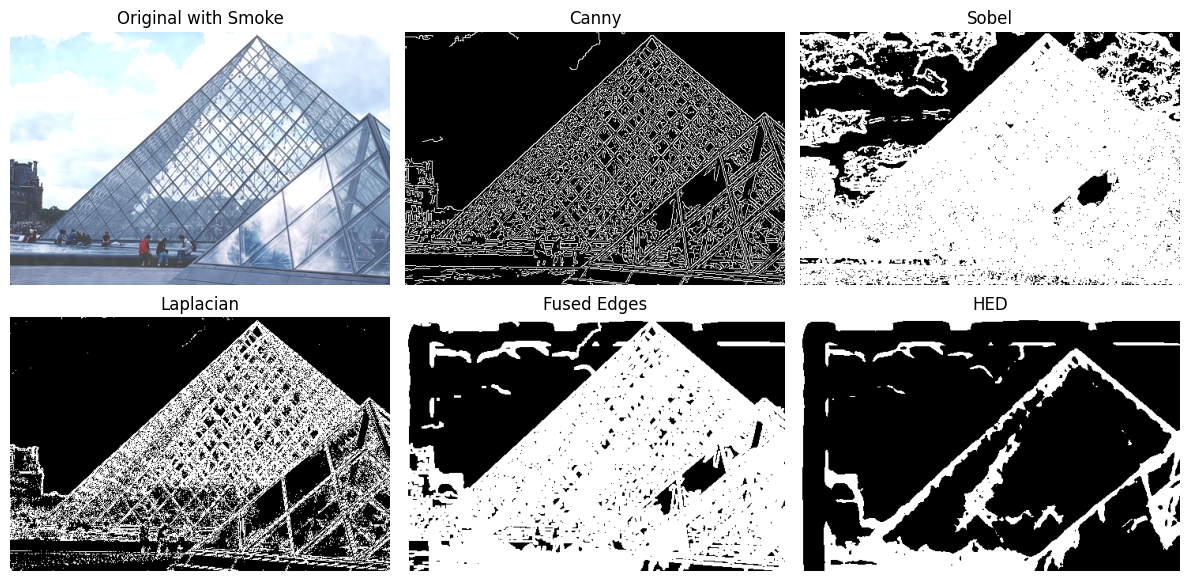

In [84]:
augmented_image = add_smoke_overlay(sample_image, opacity=0.5)

edge_canny = detect_edges_canny(augmented_image)
edge_sobel = detect_edges_sobel(augmented_image)
edge_laplacian = detect_edges_laplacian(augmented_image)
edge_hed = detect_edges_hed_deep(augmented_image)

edge_fused = weighted_fuse_edges([edge_canny, edge_hed], weights=[0.6, 0.4])

plt.figure(figsize=(12, 6))
titles = ['Original with Smoke', 'Canny', 'Sobel', 'Laplacian', 'Fused Edges', 'HED']
images = [augmented_image, edge_canny, edge_sobel, edge_laplacian, edge_fused, edge_hed]
for i, (title, img) in enumerate(zip(titles, images)):
    plt.subplot(2, 3, i + 1)
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Smoke Level Estimation Model

We build a simple CNN using Keras to classify smoke levels into Low, Medium, or High.
For demonstration purposes, we generate dummy training data using our smoke augmentation function.
In practice, train on a properly labeled dataset.


In [85]:
def create_smoke_level_model(input_shape=(128, 128, 3), num_classes=3):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


smoke_model = create_smoke_level_model()

/Users/rocker/PycharmProjects/ELG5378/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Dummy Data Generation & Model Training for Smoke Estimation

We simulate training data where:
- Label 0 (Low): opacity ≈ 0.2
- Label 1 (Medium): opacity ≈ 0.5
- Label 2 (High): opacity ≈ 0.8

In [86]:
def generate_dummy_smoke_data(num_samples=100, image_size=(128, 128)):
    X = []
    y = []
    for _ in range(num_samples):
        base_path = random.choice(image_files)
        base_img = cv2.imread(base_path)
        base_img = cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)
        base_img = cv2.resize(base_img, image_size)

        label = random.choice([0, 1, 2])
        opacity = {0: 0.2, 1: 0.5, 2: 0.8}[label]
        augmented = add_smoke_overlay(base_img, opacity)
        X.append(augmented)
        y.append(label)
    X = np.array(X).astype('float32') / 255.0
    y = to_categorical(np.array(y), num_classes=3)
    return X, y


X_dummy, y_dummy = generate_dummy_smoke_data(num_samples=800)
smoke_model.fit(X_dummy, y_dummy, epochs=20, batch_size=32)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.3795 - loss: 2.6579
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5050 - loss: 1.4691
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5698 - loss: 1.1630
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6088 - loss: 1.3807
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6587 - loss: 0.9072
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6388 - loss: 0.9968
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6914 - loss: 0.8747
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7258 - loss: 0.7855
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7857 - loss: 0.5529
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8099 - loss: 0.4387
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8329 - loss: 0.4102
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy:

### Grid Search for Medium Condition

In [87]:
def grid_search_parameters_medium(image_paths, gt_dir, threshold_grid, weight_grid):
    best_f1 = 0.0
    best_params = None
    for t_low, t_high in threshold_grid:
        for weights in weight_grid:
            f1_scores = []
            for path in image_paths:
                # Load image and preprocess
                image = cv2.imread(path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Augment with medium smoke (opacity 0.5)
                augmented = add_smoke_overlay(image, opacity=0.5)

                # Use Canny with current thresholds
                gray = cv2.cvtColor(augmented, cv2.COLOR_RGB2GRAY)
                edges_canny = cv2.Canny(gray, t_low, t_high)

                # Use the deep HED detector
                hed = detect_edges_hed_deep(augmented)

                # Fuse edges with specified weights
                fused = weighted_fuse_edges([edges_canny, hed], weights=weights)

                # Load ground truth and evaluate
                gt = load_ground_truth_edges(path, gt_dir)
                f1, _, _ = evaluate_edges(fused, gt)
                f1_scores.append(f1)
            avg_f1 = np.mean(f1_scores)
            print(f"Medium: thresholds=({t_low},{t_high}), weights={weights}, avg F1={avg_f1:.3f}")
            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_params = {'t_low': t_low, 't_high': t_high, 'weights': weights}
    return best_params, best_f1


# Example parameter grids for medium condition
threshold_grid = [(20, 80), (30, 100), (40, 120)]
weight_grid = [[0.5, 0.5], [0.6, 0.4], [0.7, 0.3]]

# Sample 20 images for grid search
sample_paths_medium = random.sample(image_files, 20)
best_params_medium, best_f1_medium = grid_search_parameters_medium(sample_paths_medium, gt_dir, threshold_grid,
                                                                   weight_grid)
print("Best parameters for Medium condition:", best_params_medium, "with avg F1:", best_f1_medium)

Medium: thresholds=(20,80), weights=[0.5, 0.5], avg F1=0.138
Medium: thresholds=(20,80), weights=[0.6, 0.4], avg F1=0.138
Medium: thresholds=(20,80), weights=[0.7, 0.3], avg F1=0.138
Medium: thresholds=(30,100), weights=[0.5, 0.5], avg F1=0.141
Medium: thresholds=(30,100), weights=[0.6, 0.4], avg F1=0.141
Medium: thresholds=(30,100), weights=[0.7, 0.3], avg F1=0.141
Medium: thresholds=(40,120), weights=[0.5, 0.5], avg F1=0.143
Medium: thresholds=(40,120), weights=[0.6, 0.4], avg F1=0.143
Medium: thresholds=(40,120), weights=[0.7, 0.3], avg F1=0.143
Best parameters for Medium condition: {'t_low': 40, 't_high': 120, 'weights': [0.6, 0.4]} with avg F1: 0.14309477909455035


### Grid Search for High Condition

In [89]:
def advanced_denoise(image):
    # Use OpenCV's fast non-local means denoising for colored images
    return cv2.fastNlMeansDenoisingColored(image, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)

def grid_search_parameters_high(image_paths, gt_dir, threshold_grid, weight_grid):
    best_f1 = 0.0
    best_params = None
    for t_low, t_high in threshold_grid:
        for weights in weight_grid:
            f1_scores = []
            for path in image_paths:
                # Load image and preprocess
                image = cv2.imread(path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Augment with high smoke (opacity 0.7)
                augmented = add_smoke_overlay(image, opacity=0.7)
                # Apply advanced denoising for high smoke condition
                image_denoised = advanced_denoise(augmented)

                # Use Laplacian and Sobel detectors
                lap = detect_edges_laplacian(image_denoised)
                sobel = detect_edges_sobel(image_denoised)

                # Fuse edges with specified weights
                fused = weighted_fuse_edges([lap, sobel], weights=weights)

                # Load ground truth and evaluate
                gt = load_ground_truth_edges(path, gt_dir)
                f1, _, _ = evaluate_edges(fused, gt)
                f1_scores.append(f1)
            avg_f1 = np.mean(f1_scores)
            print(f"High: thresholds=({t_low},{t_high}), weights={weights}, avg F1={avg_f1:.3f}")
            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_params = {'t_low': t_low, 't_high': t_high, 'weights': weights}
    return best_params, best_f1


# For high condition, you might not need thresholds for the denoising step,
# but you could include thresholds if you plan to modify the detectors.
# Here, assume thresholds affect the underlying Canny-like processing within each detector.
# Example grids (can be adjusted):
threshold_grid_high = [(20, 80), (30, 100), (40, 120)]
weight_grid_high = [[0.5, 0.5], [0.6, 0.4], [0.7, 0.3]]

# Sample 20 images for high condition grid search
sample_paths_high = random.sample(image_files, 20)
best_params_high, best_f1_high = grid_search_parameters_high(sample_paths_high, gt_dir, threshold_grid_high,
                                                             weight_grid_high)
print("Best parameters for High condition:", best_params_high, "with avg F1:", best_f1_high)

High: thresholds=(20,80), weights=[0.5, 0.5], avg F1=0.148
High: thresholds=(20,80), weights=[0.6, 0.4], avg F1=0.148
High: thresholds=(20,80), weights=[0.7, 0.3], avg F1=0.148
High: thresholds=(30,100), weights=[0.5, 0.5], avg F1=0.148
High: thresholds=(30,100), weights=[0.6, 0.4], avg F1=0.148
High: thresholds=(30,100), weights=[0.7, 0.3], avg F1=0.148
High: thresholds=(40,120), weights=[0.5, 0.5], avg F1=0.148
High: thresholds=(40,120), weights=[0.6, 0.4], avg F1=0.148
High: thresholds=(40,120), weights=[0.7, 0.3], avg F1=0.148
Best parameters for High condition: {'t_low': 30, 't_high': 100, 'weights': [0.7, 0.3]} with avg F1: 0.14832322428737751


### Smoke Level Prediction Function
This function resizes the image, predicts the smoke level, and maps the output to a label.

In [90]:
def predict_smoke_level(image, model, target_size=(128, 128)):
    resized = cv2.resize(image, target_size)
    input_img = resized.astype('float32') / 255.0
    input_img = np.expand_dims(input_img, axis=0)
    preds = model.predict(input_img)
    level = np.argmax(preds)
    mapping = {0: 'Low', 1: 'Medium', 2: 'High'}
    return mapping[level]

## 6. Adaptive Edge Detection System

Based on the predicted smoke level, we choose an edge detection algorithm:
- **Low:** Use Canny.
- **Medium:** Use simulated HED.
- **High:** Enhance contrast then use Laplacian.

In [91]:
def adaptive_edge_detection(image, smoke_model):
    level = predict_smoke_level(image, smoke_model)
    print(f"Predicted Smoke Level: {level}")

    if level == 'Low':
        edges = detect_edges_canny(image)
    elif level == 'Medium':
        canny = detect_edges_canny(image, 40, 120)
        hed = detect_edges_hed_deep(image)  # Use the deep HED detector
        # Use weighted fusion, e.g., weight 0.6 for Canny and 0.4 for HED
        edges = weighted_fuse_edges([canny, hed], weights=[0.6, 0.4])
    elif level == 'High':
        # Apply advanced denoising
        image_denoised = advanced_denoise(image)
        # Use multi-scale Laplacian and Sobel detectors
        lap = detect_edges_laplacian(image_denoised)
        sobel = detect_edges_sobel(image_denoised)
        # Use equal weights for fusion
        edges = weighted_fuse_edges([lap, sobel], weights=[0.7, 0.3])
    else:
        edges = detect_edges_canny(image)

    return edges, level

### Test Adaptive Edge Detection on a Smoke-Augmented BSDS500 Sample

We run the adaptive system on our augmented sample image and display the result.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Predicted Smoke Level: Medium


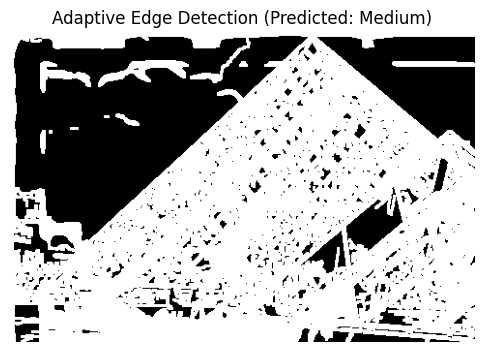

In [92]:
adaptive_edges, predicted_level = adaptive_edge_detection(augmented_image, smoke_model)
plt.figure(figsize=(6, 6))
plt.imshow(adaptive_edges, cmap='gray')
plt.title(f'Adaptive Edge Detection (Predicted: {predicted_level})')
plt.axis('off')
plt.show()

## 7. Accuracy Verification

We evaluate the detected edges against the ground truth using F1-score, IoU, and SSIM.
Ground truth is loaded from the corresponding .mat file in the BSDS500 dataset.

In [93]:
def evaluate_edges(predicted, ground_truth):
    # Resize ground truth if needed
    if predicted.shape != ground_truth.shape:
        ground_truth = cv2.resize(ground_truth, (predicted.shape[1], predicted.shape[0]))

    # Dilate predicted edges to allow slight misalignment overlap
    kernel = np.ones((3, 3), np.uint8)
    predicted_dilated = cv2.dilate(predicted, kernel, iterations=1)

    pred_flat = (predicted_dilated.flatten() / 255).astype(np.uint8)
    gt_flat = (ground_truth.flatten() / 255).astype(np.uint8)

    f1 = f1_score(gt_flat, pred_flat, zero_division=1)
    iou = jaccard_score(gt_flat, pred_flat, zero_division=1)
    ssim_score = ssim(ground_truth, predicted_dilated)
    return f1, iou, ssim_score


# Load ground truth edge map corresponding to the sample image
ground_truth = load_ground_truth_edges(sample_image_path, gt_dir)
f1, iou, ssim_val = evaluate_edges(adaptive_edges, ground_truth)
print(f"Evaluation Metrics on Sample Image:\nF1-score: {f1:.3f}\nIoU: {iou:.3f}\nSSIM: {ssim_val:.3f}")

Evaluation Metrics on Sample Image:
F1-score: 0.110
IoU: 0.058
SSIM: 0.209


## 8. Final Pipeline: Hybrid Adaptive Edge Detection System

This function wraps the full pipeline:
1. Preprocess the image (contrast enhancement).
2. Predict the smoke level.
3. Select and apply the appropriate edge detection algorithm.
4. Evaluate the edge map against ground truth.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted Smoke Level: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Smoke Level: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Smoke Level: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Smoke Level: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Smoke Level: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Smoke Level: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Smoke Level: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Smoke Level: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Smoke Level: Low
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Smoke Level: Low


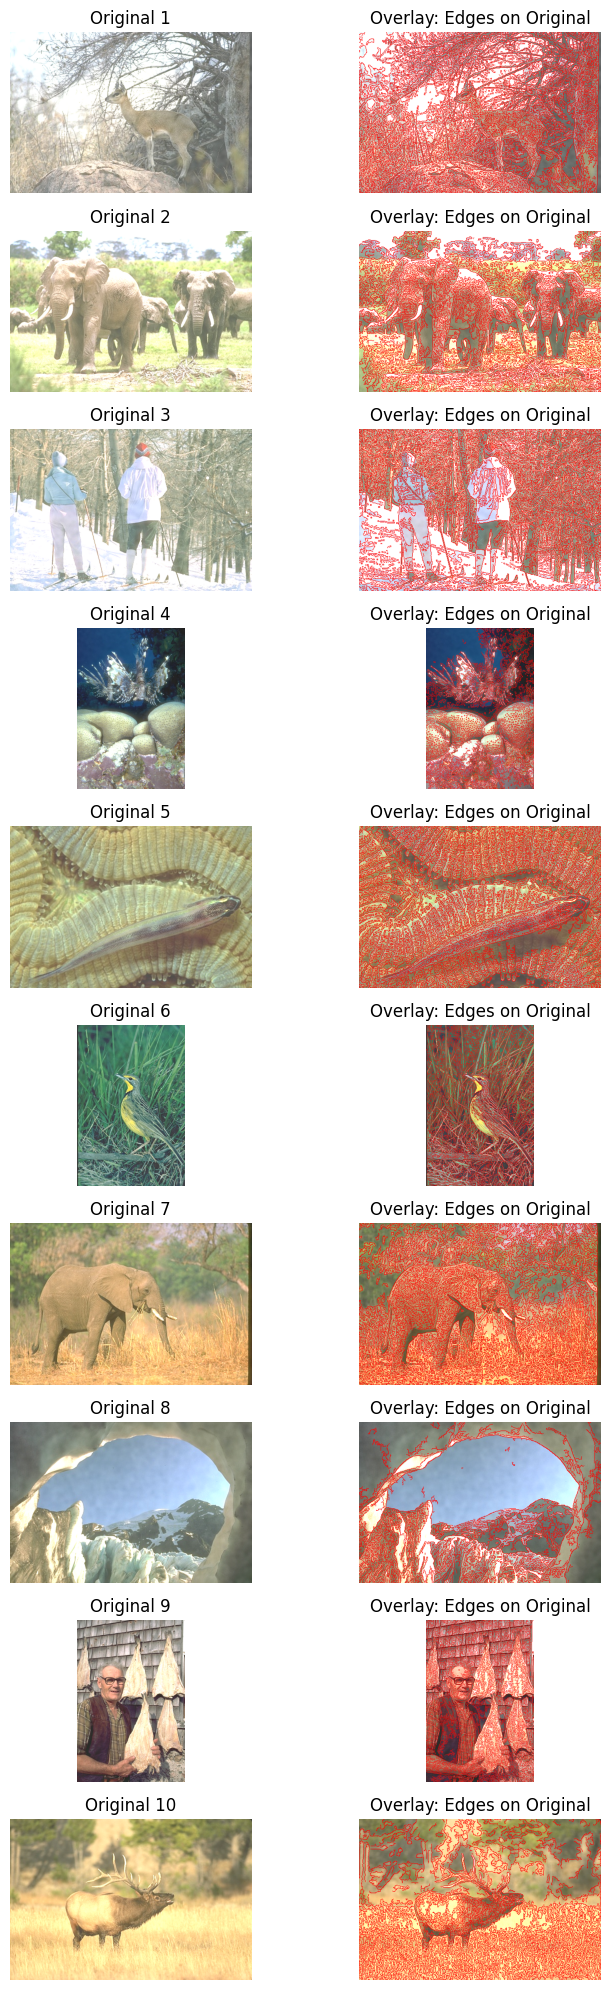

,Image,Smoke Level,Detector,F1,IoU,SSIM
0,77062.jpg,Low,Canny,0.196290,0.108825,0.021421
1,253016.jpg,Low,Canny,0.223255,0.125654,0.074676
2,277053.jpg,Low,Canny,0.176396,0.096729,0.061635
3,306051.jpg,Low,Canny,0.177006,0.097096,0.128030
4,209021.jpg,Low,Canny,0.096620,0.050762,0.025957
5,268074.jpg,Low,Canny,0.138439,0.074367,0.009738
6,107014.jpg,Low,Canny,0.142491,0.076711,0.023889
7,176051.jpg,Low,Canny,0.156180,0.084705,0.425513
8,365072.jpg,Low,Canny,0.168410,0.091948,0.026583
9,41006.jpg,Low,Canny,0.110956,0.058736,0.108358


In [94]:
def final_pipeline(image, image_path, smoke_model, gt_dir):
    # Preprocess: Enhance contrast using histogram equalization
    preprocessed = image.copy()
    if len(image.shape) == 3:
        preprocessed_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        preprocessed_gray = cv2.equalizeHist(preprocessed_gray)
        preprocessed = cv2.cvtColor(preprocessed_gray, cv2.COLOR_GRAY2RGB)

    edges, level = adaptive_edge_detection(preprocessed, smoke_model)
    gt = load_ground_truth_edges(image_path, gt_dir)
    f1, iou, ssim_val = evaluate_edges(edges, gt)
    return edges, level, f1, iou, ssim_val


def overlay_edges_on_image(image, edges):
    overlay = image.copy()
    overlay[edges > 0] = [255, 0, 0]
    return overlay


# Batch evaluation on 10 random images
num_samples = 10
sample_paths = random.sample(image_files, num_samples)

results = []
fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 2))

for idx, path in enumerate(sample_paths):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augmented = add_smoke_overlay(image, opacity=random.uniform(0.2, 0.8))
    final_edges, final_level, final_f1, final_iou, final_ssim = final_pipeline(
        augmented, path, smoke_model, gt_dir)

    results.append({
        'Image': os.path.basename(path),
        'Smoke Level': final_level,
        'Detector': 'Fused' if final_level in ['Medium', 'High'] else 'Canny',
        'F1': final_f1,
        'IoU': final_iou,
        'SSIM': final_ssim
    })

    overlay_img = overlay_edges_on_image(augmented, final_edges)
    axes[idx, 0].imshow(augmented)
    axes[idx, 0].set_title(f'Original {idx + 1}')
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(overlay_img)
    axes[idx, 1].set_title('Overlay: Edges on Original')
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

# Display results as DataFrame
results_df = pd.DataFrame(results)
display(results_df)

## Conclusion

In this notebook we have:
- Loaded the BSDS500 dataset and ground truth annotations.
- Augmented images with simulated smoke overlays.
- Implemented multiple edge detection algorithms.
- Built a simple CNN to predict smoke level.
- Designed an adaptive system that selects the best edge detector based on smoke intensity.
- Evaluated the performance using standard metrics.

This hybrid approach can be further refined with more advanced edge detectors and real smoke-labeled data.